In [1]:
import matplotlib.pylab as plt
%matplotlib inline
import pandas as pd

from pyspark.ml.clustering import KMeans
from pyspark.ml.linalg import Vectors
from pyspark.sql import Row, SparkSession, SQLContext

**Creating the Spark Session (to work with Spark)**

In [2]:
spSession = SparkSession.builder.master('local').appName('appSparkSql').getOrCreate()

**Loading and storing the object in memory, for better performance**

In [3]:
rddCarsCsv = sc.textFile('aux/datasets/cars.csv')
rddCarsCsv.count()

198

In [4]:
rddCarsCsv.cache()

aux/datasets/cars.csv MapPartitionsRDD[1] at textFile at NativeMethodAccessorImpl.java:0

**Removing the header**

In [5]:
header = rddCarsCsv.first()
rddCars = rddCarsCsv.filter(lambda line: line != header)
rddCars.count()

197

In [6]:
def toNumber(line):
    
    attrList = line.split(',')
    
    doors = 1.0 if attrList[3] == 'two'   else 2.0
    body  = 1.0 if attrList[4] == 'sedan' else 2.0 
       
    newLine = Row( \
        DOORS = doors, \
        BODY = float(body), \
        HP = float(attrList[7]), \
        RPM = float(attrList[8]), \
        MPG = float(attrList[9]))
    
    return newLine

**Applying the function to the data**

In [7]:
carsMap = rddCars.map(toNumber)

**Persisting the result in memory, for better performance**

In [8]:
carsMap.persist()

PythonRDD[5] at RDD at PythonRDD.scala:53

**Listing the results**

In [9]:
carsMap.collect()

[Row(DOORS=1.0, BODY=2.0, HP=69.0, RPM=4900.0, MPG=31.0),
 Row(DOORS=1.0, BODY=2.0, HP=48.0, RPM=5100.0, MPG=47.0),
 Row(DOORS=1.0, BODY=2.0, HP=68.0, RPM=5000.0, MPG=30.0),
 Row(DOORS=1.0, BODY=2.0, HP=62.0, RPM=4800.0, MPG=35.0),
 Row(DOORS=1.0, BODY=2.0, HP=68.0, RPM=5500.0, MPG=37.0),
 Row(DOORS=1.0, BODY=2.0, HP=60.0, RPM=5500.0, MPG=38.0),
 Row(DOORS=1.0, BODY=1.0, HP=69.0, RPM=5200.0, MPG=31.0),
 Row(DOORS=1.0, BODY=2.0, HP=68.0, RPM=5500.0, MPG=37.0),
 Row(DOORS=1.0, BODY=2.0, HP=68.0, RPM=5500.0, MPG=37.0),
 Row(DOORS=1.0, BODY=2.0, HP=68.0, RPM=5000.0, MPG=31.0),
 Row(DOORS=1.0, BODY=2.0, HP=68.0, RPM=5500.0, MPG=31.0),
 Row(DOORS=2.0, BODY=2.0, HP=68.0, RPM=5500.0, MPG=31.0),
 Row(DOORS=2.0, BODY=2.0, HP=68.0, RPM=5500.0, MPG=31.0),
 Row(DOORS=1.0, BODY=2.0, HP=70.0, RPM=5400.0, MPG=38.0),
 Row(DOORS=1.0, BODY=2.0, HP=62.0, RPM=4800.0, MPG=31.0),
 Row(DOORS=1.0, BODY=2.0, HP=68.0, RPM=5500.0, MPG=31.0),
 Row(DOORS=1.0, BODY=2.0, HP=58.0, RPM=4800.0, MPG=49.0),
 Row(DOORS=2.0

**Creating the DataFrame**

In [10]:
dfCars = spSession.createDataFrame(carsMap)

In [11]:
dfCars.show(10)

+-----+----+----+------+----+
|DOORS|BODY|  HP|   RPM| MPG|
+-----+----+----+------+----+
|  1.0| 2.0|69.0|4900.0|31.0|
|  1.0| 2.0|48.0|5100.0|47.0|
|  1.0| 2.0|68.0|5000.0|30.0|
|  1.0| 2.0|62.0|4800.0|35.0|
|  1.0| 2.0|68.0|5500.0|37.0|
|  1.0| 2.0|60.0|5500.0|38.0|
|  1.0| 1.0|69.0|5200.0|31.0|
|  1.0| 2.0|68.0|5500.0|37.0|
|  1.0| 2.0|68.0|5500.0|37.0|
|  1.0| 2.0|68.0|5000.0|31.0|
+-----+----+----+------+----+
only showing top 10 rows



**DataSet Statistics with Pandas**

In [12]:
dataStats = dfCars.describe().toPandas()

In [13]:
dataStats

,summary,DOORS,BODY,HP,RPM,MPG
0,count,197,197,197,197,197
1,mean,1.5685279187817258,1.532994923857868,103.60406091370558,5118.0203045685275,25.15228426395939
2,stddev,0.49654352778167493,0.5001812579359883,37.639205349518356,481.03591405011446,6.437862917085915
3,min,1.0,1.0,48.0,4150.0,13.0
4,max,2.0,2.0,262.0,6600.0,49.0


In [14]:
means = dataStats.iloc[1, 1:5].values.tolist()

In [15]:
means

['1.5685279187817258',
 '1.532994923857868',
 '103.60406091370558',
 '5118.0203045685275']

In [16]:
stdds = dataStats.iloc[2, 1:5].values.tolist()

In [17]:
stdds

['0.49654352778167493',
 '0.5001812579359883',
 '37.639205349518356',
 '481.03591405011446']

**Broadcast object to store means and standard deviations**

In [18]:
bcMeans = sc.broadcast(means)
bcStdds = sc.broadcast(stdds)

**Function to normalize data and create a dense vector**

In [19]:
def centerAndScale(inRow):
    
    global bcMeans
    global bcStdds
    
    arrMeans = bcMeans.value
    arrStdds = bcStdds.value
    
    arrReturn = []
    
    for i in range(len(arrMeans)):
        arrReturn.append((float(inRow[i]) - float(arrMeans[i])) / float(arrStdds[i]))
        
    return Vectors.dense(arrReturn)

**Normalizing the Data**

In [20]:
rddCarsNormalized = dfCars.rdd.map(centerAndScale)

In [21]:
rddCarsNormalized.collect()

[DenseVector([-1.145, 0.9337, -0.9194, -0.4532]),
 DenseVector([-1.145, 0.9337, -1.4773, -0.0375]),
 DenseVector([-1.145, 0.9337, -0.9459, -0.2453]),
 DenseVector([-1.145, 0.9337, -1.1053, -0.6611]),
 DenseVector([-1.145, 0.9337, -0.9459, 0.7941]),
 DenseVector([-1.145, 0.9337, -1.1585, 0.7941]),
 DenseVector([-1.145, -1.0656, -0.9194, 0.1704]),
 DenseVector([-1.145, 0.9337, -0.9459, 0.7941]),
 DenseVector([-1.145, 0.9337, -0.9459, 0.7941]),
 DenseVector([-1.145, 0.9337, -0.9459, -0.2453]),
 DenseVector([-1.145, 0.9337, -0.9459, 0.7941]),
 DenseVector([0.869, 0.9337, -0.9459, 0.7941]),
 DenseVector([0.869, 0.9337, -0.9459, 0.7941]),
 DenseVector([-1.145, 0.9337, -0.8928, 0.5862]),
 DenseVector([-1.145, 0.9337, -1.1053, -0.6611]),
 DenseVector([-1.145, 0.9337, -0.9459, 0.7941]),
 DenseVector([-1.145, 0.9337, -1.2116, -0.6611]),
 DenseVector([0.869, 0.9337, -1.1053, -0.6611]),
 DenseVector([-1.145, 0.9337, -0.7334, 1.8335]),
 DenseVector([0.869, -1.0656, -0.8928, 0.5862]),
 DenseVector([

**Creating a Spark dataFrame with features**

In [22]:
plCarsRows = rddCarsNormalized.map(lambda line: Row(features = line))

In [23]:
dfCarsFeatures = spSession.createDataFrame(plCarsRows)

In [24]:
dfCarsFeatures.select('features').show(10)

+--------------------+
|            features|
+--------------------+
|[-1.1449709581789...|
|[-1.1449709581789...|
|[-1.1449709581789...|
|[-1.1449709581789...|
|[-1.1449709581789...|
|[-1.1449709581789...|
|[-1.1449709581789...|
|[-1.1449709581789...|
|[-1.1449709581789...|
|[-1.1449709581789...|
+--------------------+
only showing top 10 rows



**KMeans for clustering**

In [25]:
kmeans = KMeans(k = 3, seed = 1)

In [26]:
model = kmeans.fit(dfCarsFeatures)

In [27]:
predictions = model.transform(dfCarsFeatures)

In [28]:
predictions.show(10)

+--------------------+----------+
|            features|prediction|
+--------------------+----------+
|[-1.1449709581789...|         0|
|[-1.1449709581789...|         0|
|[-1.1449709581789...|         0|
|[-1.1449709581789...|         0|
|[-1.1449709581789...|         0|
|[-1.1449709581789...|         0|
|[-1.1449709581789...|         0|
|[-1.1449709581789...|         0|
|[-1.1449709581789...|         0|
|[-1.1449709581789...|         0|
+--------------------+----------+
only showing top 10 rows



**Plotting**

In [29]:
def unstripData(data):
    return(data['prediction'], data['features'][0], data['features'][1], data['features'][2], data['features'][3])

In [30]:
unstripedData = predictions.rdd.map(unstripData)

In [31]:
predictionList = unstripedData.collect()

In [32]:
dfPredictions = pd.DataFrame(predictionList)

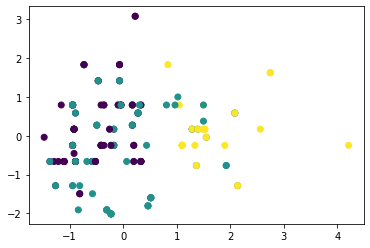

In [33]:
plt.cla()
plt.scatter(dfPredictions[3], dfPredictions[4], c = dfPredictions[0]);